# Imports

In [1]:
import os
import glob
import json
import ast
import re

from typing import Dict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [2]:
def get_metabolite_info():
    metabolite_data = pd.read_csv('./data/metabolites.txt', delimiter='\t')
    raw_metabolites = pd.read_csv('./data/metabolites_dataset.data_prep.tsv', delimiter='\t')

    return raw_metabolites.merge(
        metabolite_data, 
        left_on='official_name', right_on='met_name'
    )[['metabolite_id', 'official_name', 'kegg_id', 'pathway', 'method', 'Order']].drop_duplicates().set_index('metabolite_id')

In [3]:
metabolite_info = get_metabolite_info()

In [4]:
metabolite_info

,official_name,kegg_id,pathway,method,Order
metabolite_id,,,,,
adp,ADP,C00008,Energy metabolism,PPP,2
amp,AMP,C00020,Energy metabolism,PPP,3
atp,ATP,C00002,Energy metabolism,PPP,1
accoa,Acetyl-CoA,C00024,TCA,TCA,1
dhap,Dihydroxyacetone phosphate,C00111,Glycolysis,TCA,5
f6p,D-Fructose 6-phosphate,C00085,Glycolysis,TCA,2
fum,Fumarate,C00122,TCA,TCA,6
g3p,Glyceraldehyde 3-phosphate,C00661,Glycolysis,TCA,4
mal-L,L-Malate,C00149,TCA,TCA,7


# Experiments

## Experiments simple baseline

In [5]:
dir = "/home/tvangraft/tudelft/thesis/metaengineering/data/results/experiment_simple_baseline"
paths = glob.glob(dir + "/*.csv")

In [6]:
# {
#     'regressor__regressor': [GammaRegressor()],
#     'regressor__regressor__alpha': [0, 1, 10],
#     'transformer': [MinMaxScaler()],
# }, {
#     'regressor__regressor': [DecisionTreeRegressor()],
#     'regressor__regressor__criterion': ['squared_error', 'friedman_mse'],
#     'regressor__regressor__max_depth': [None, 5, 10, 20, 15]
# }, {
#     'regressor__regressor': [SVR()],
#     'regressor__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
# }, {
#     'regressor__regressor': [ElasticNet()],
#     'regressor__regressor__l1_ratio': [0, 0.25, 0.5, 0.75, 1],
# }

In [ ]:
def rename(name: str):
    name = name.removeprefix('param_regressor__')
    name = name.removesuffix('_test_score')
    return name

def fmt(param: str):
    param = param.replace('{', '').replace('}', '').replace('regressor__regressor__', '').replace("\'", '')
    param = param.split(',')[1:]
    param = [param.strip() for param in param if "=" not in param]
    return '\n'.join(param)

In [ ]:
metabolites_names = [path.rsplit('/', 1)[1].removesuffix('.csv').removeprefix('Strategy.METABOLITE_CENTRIC_') for path in paths]
df = pd.concat([
    pd.read_csv(path).assign(metabolite_id=metabolite_name) 
    for path, metabolite_name in zip(paths, metabolites_names)
])
df.columns = df.columns.map(lambda name: rename(name))
df['regressor'] = df['regressor'].replace(to_replace=r'^DecisionTreeRegressor.*', value="DecisionTreeRegressor()", regex=True)
df['mean'] = -1 * df['mean']
df['std'] = -1 * df['std']
df['regressor'].replace(to_replace=r'^DecisionTreeRegressor.*', value="DecisionTreeRegressor()", regex=True).unique()
df['params_fmt'] = df['params'].map(lambda param: fmt(param))
df = df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
df

In [57]:
test_df = pd.read_csv(
    './data/results/experiment_simple_baseline/best_model_performance.csv',
    index_col=0
)
test_df = test_df.stack().to_frame().reset_index(1).set_axis(['metabolite_id', 'r2'], axis=1)
test_df = test_df.merge(metabolite_info, left_on='metabolite_id', right_index=True)
test_df

,metabolite_id,r2,official_name,kegg_id,pathway,method,Order
0,6pgc,-0.012864,6-Phospho-D-gluconate,C00345,PPP,TCA,1
1,6pgc,-0.012864,6-Phospho-D-gluconate,C00345,PPP,TCA,1
2,6pgc,-0.012864,6-Phospho-D-gluconate,C00345,PPP,TCA,1
3,6pgc,-0.012864,6-Phospho-D-gluconate,C00345,PPP,TCA,1
4,6pgc,-0.012864,6-Phospho-D-gluconate,C00345,PPP,TCA,1
...,...,...,...,...,...,...,...
95,atp,-0.273993,ATP,C00002,Energy metabolism,PPP,1
96,atp,-0.273993,ATP,C00002,Energy metabolism,PPP,1
97,atp,-0.273993,ATP,C00002,Energy metabolism,PPP,1
98,atp,-0.273993,ATP,C00002,Energy metabolism,PPP,1


In [8]:
df['metabolite_id'].unique()

array(['oaa', 'asn-L', 'r5p', 'citr-L', 'hom-L', 'lys-L', 'glu-L',
       'his-L', 'dhap', 'orn', 'leu-L', 'arg-L', 'akg', 'gln-L', '6pgc',
       'ser-L', 'phe-L', 'mal-L', 'tyr-L', 'fum', 'amp', 'pyr', 'succ',
       'g3p', 'ru5p-D', 'adp', 'hcys-L', 'met-L', 'gly', 'cit', 'atp',
       'thr-L', 'val-L', 's7p', 'asp-L', 'f6p', 'fdp', 'pep', 'trp-L',
       'pro-L', 'accoa'], dtype=object)

In [9]:
# these metabolites need some further investigation as we do not know to which pathway they belong
df[~df['metabolite_id'].isin(metabolite_info.index)][['metabolite_id']].drop_duplicates()

,metabolite_id


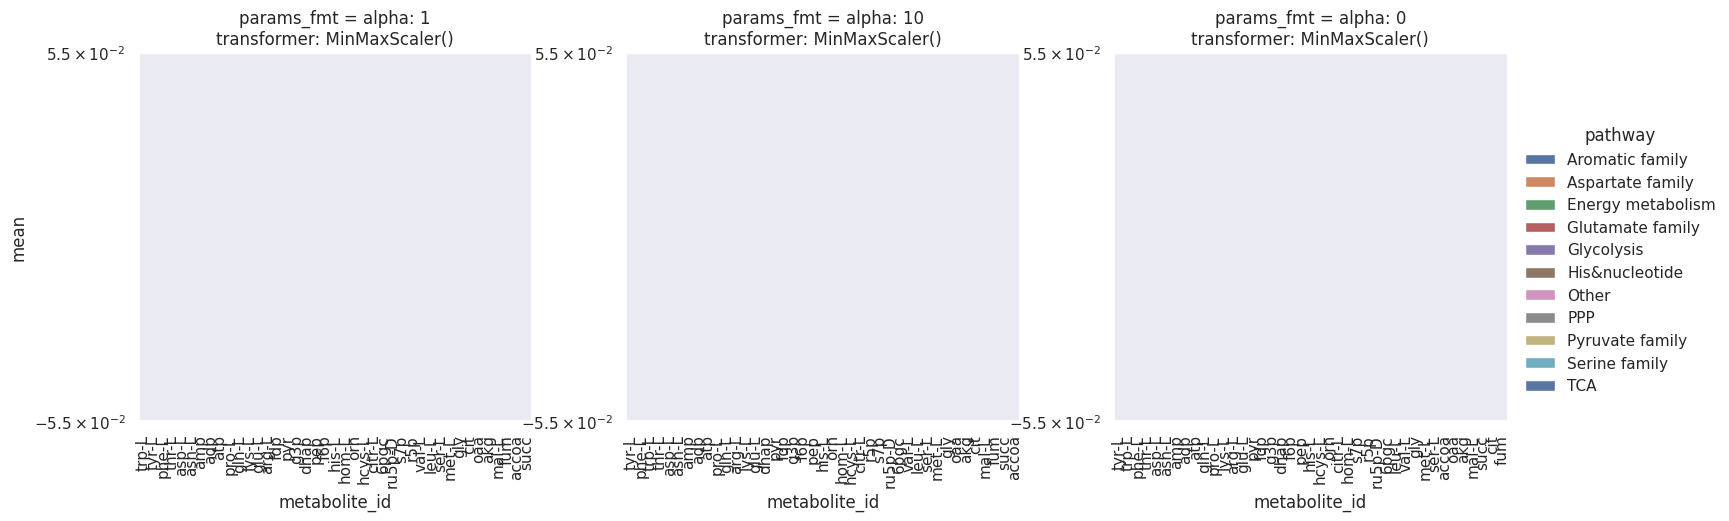

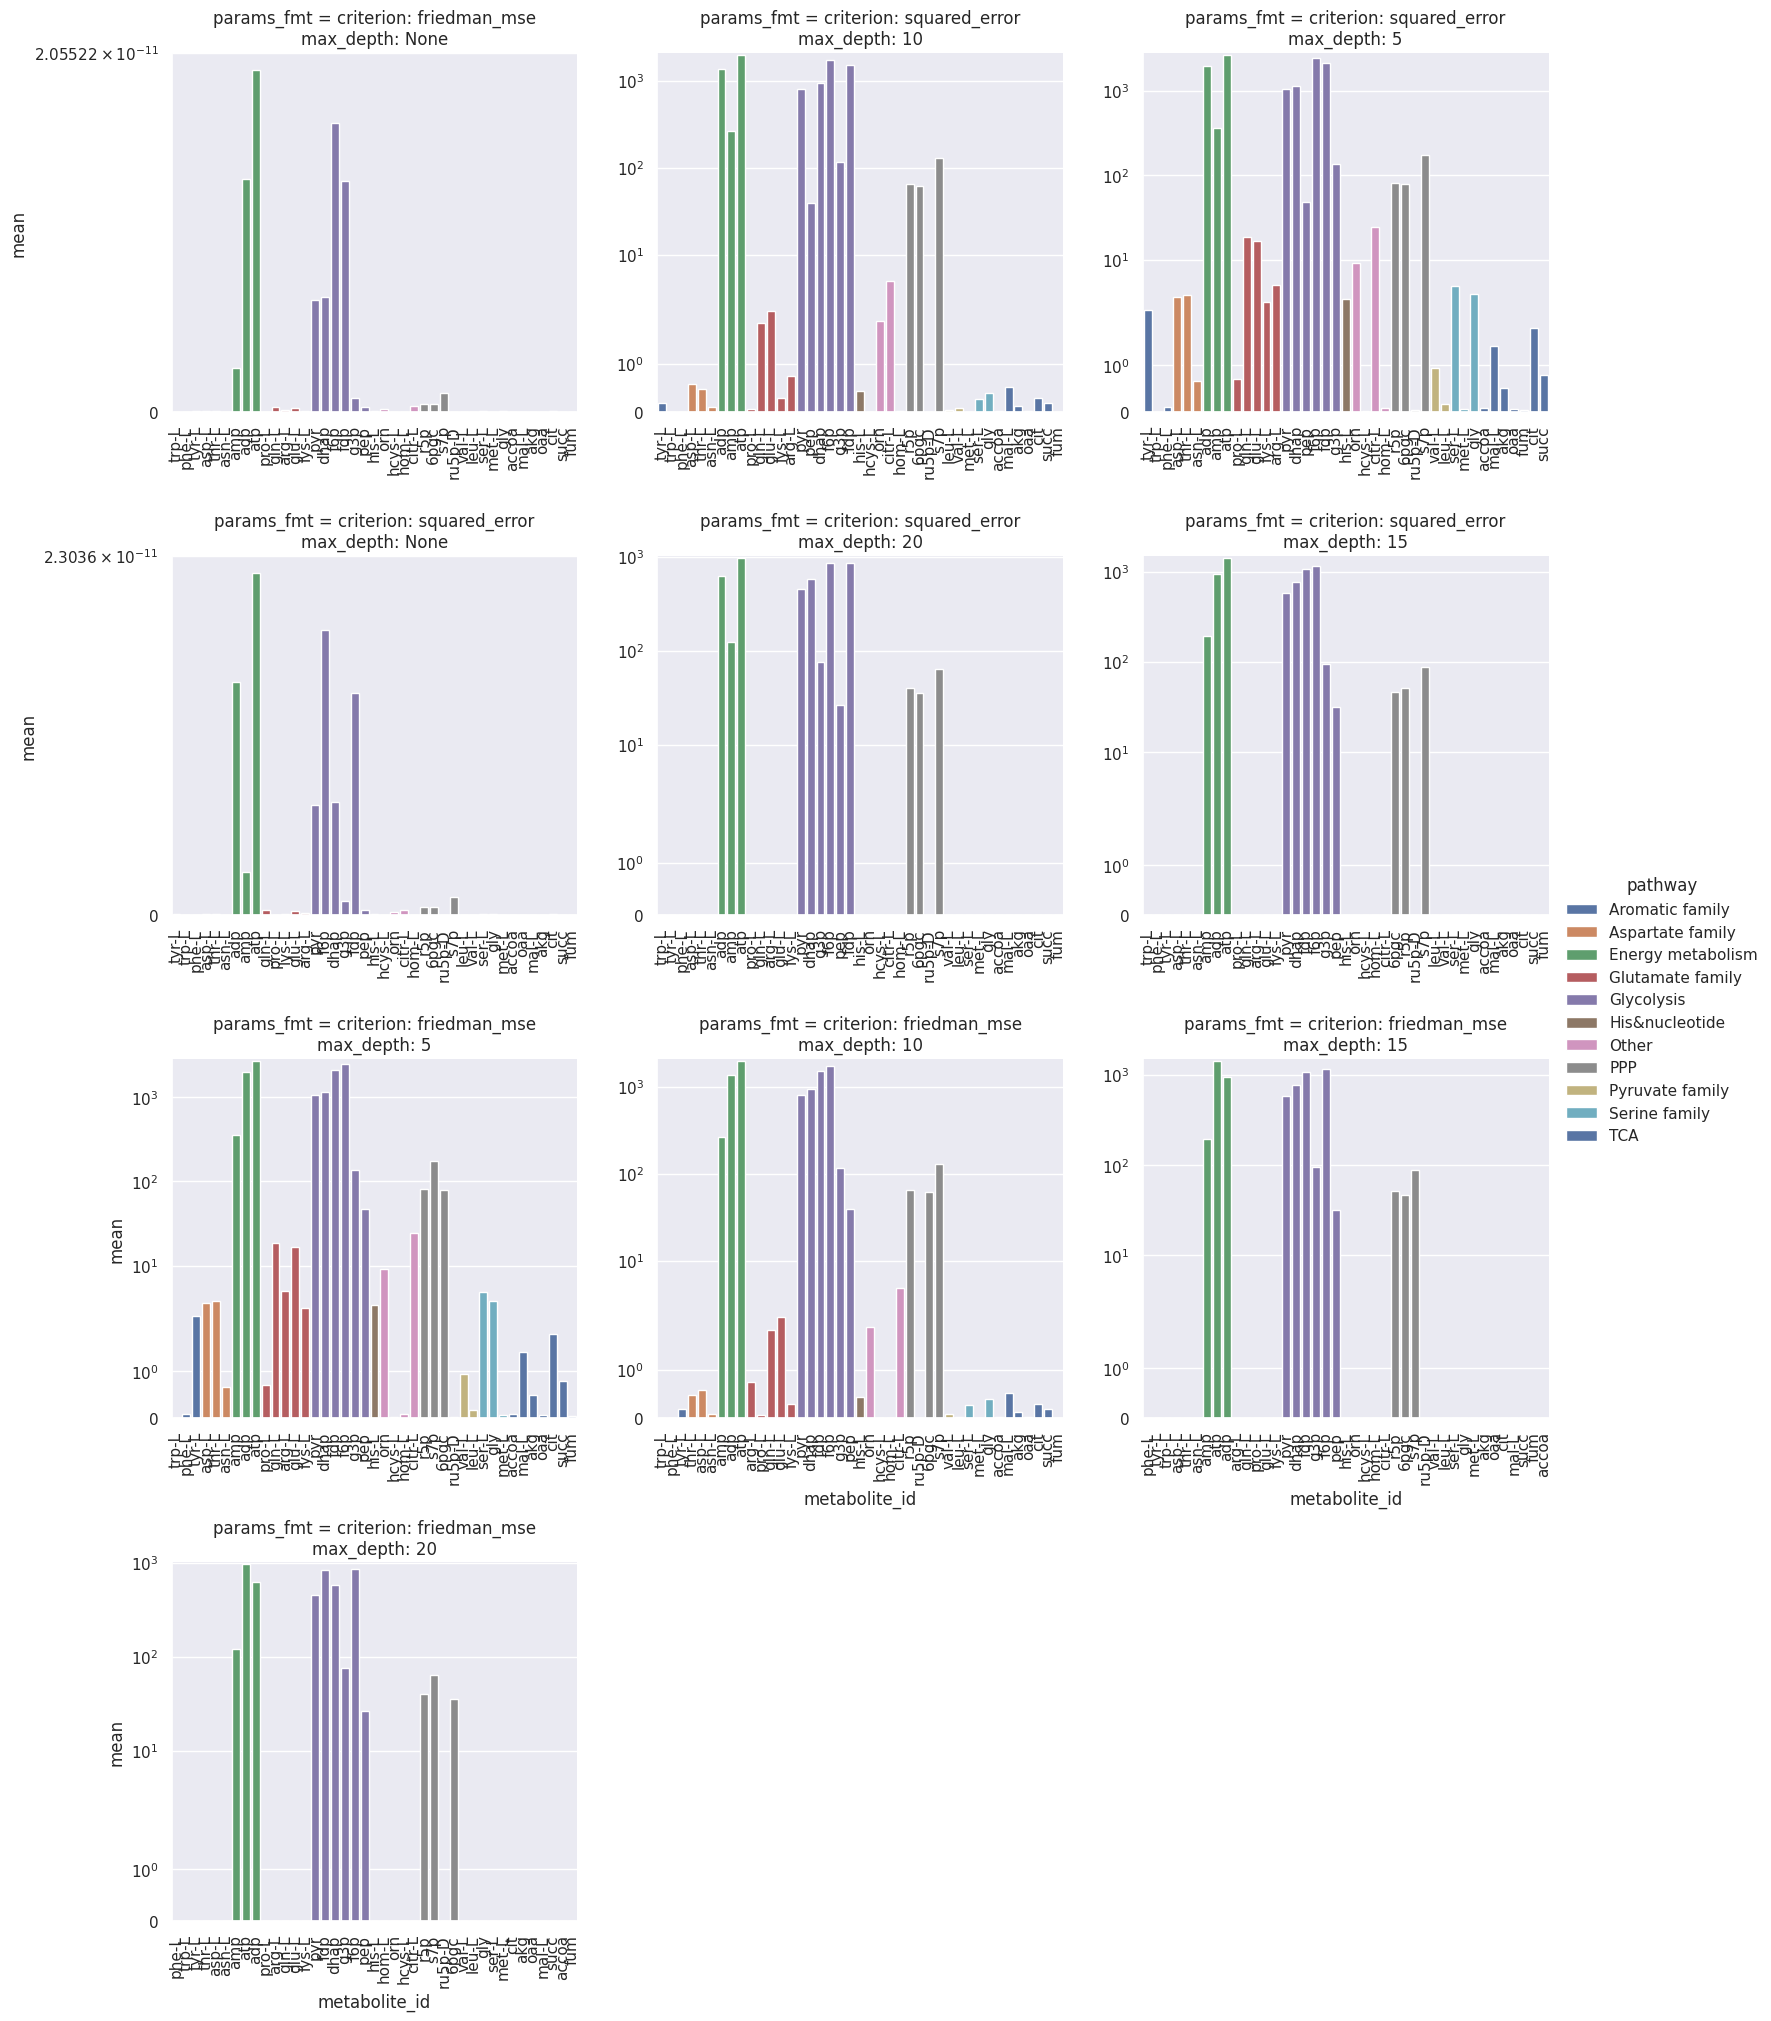

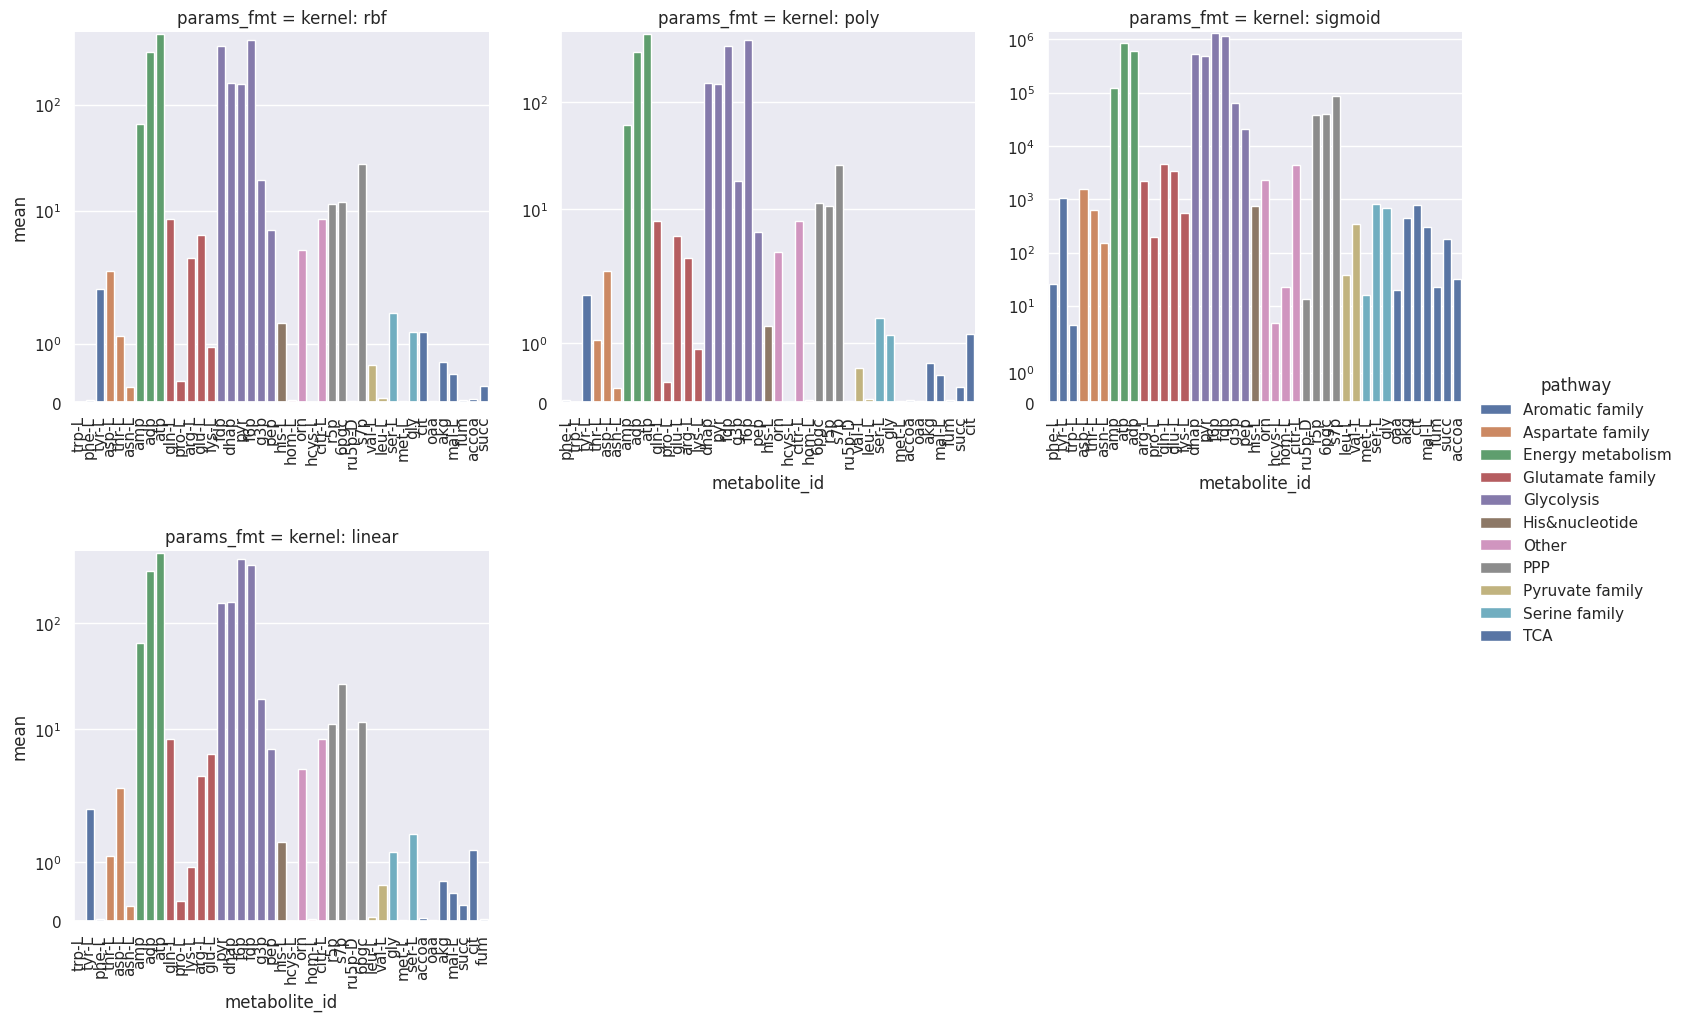

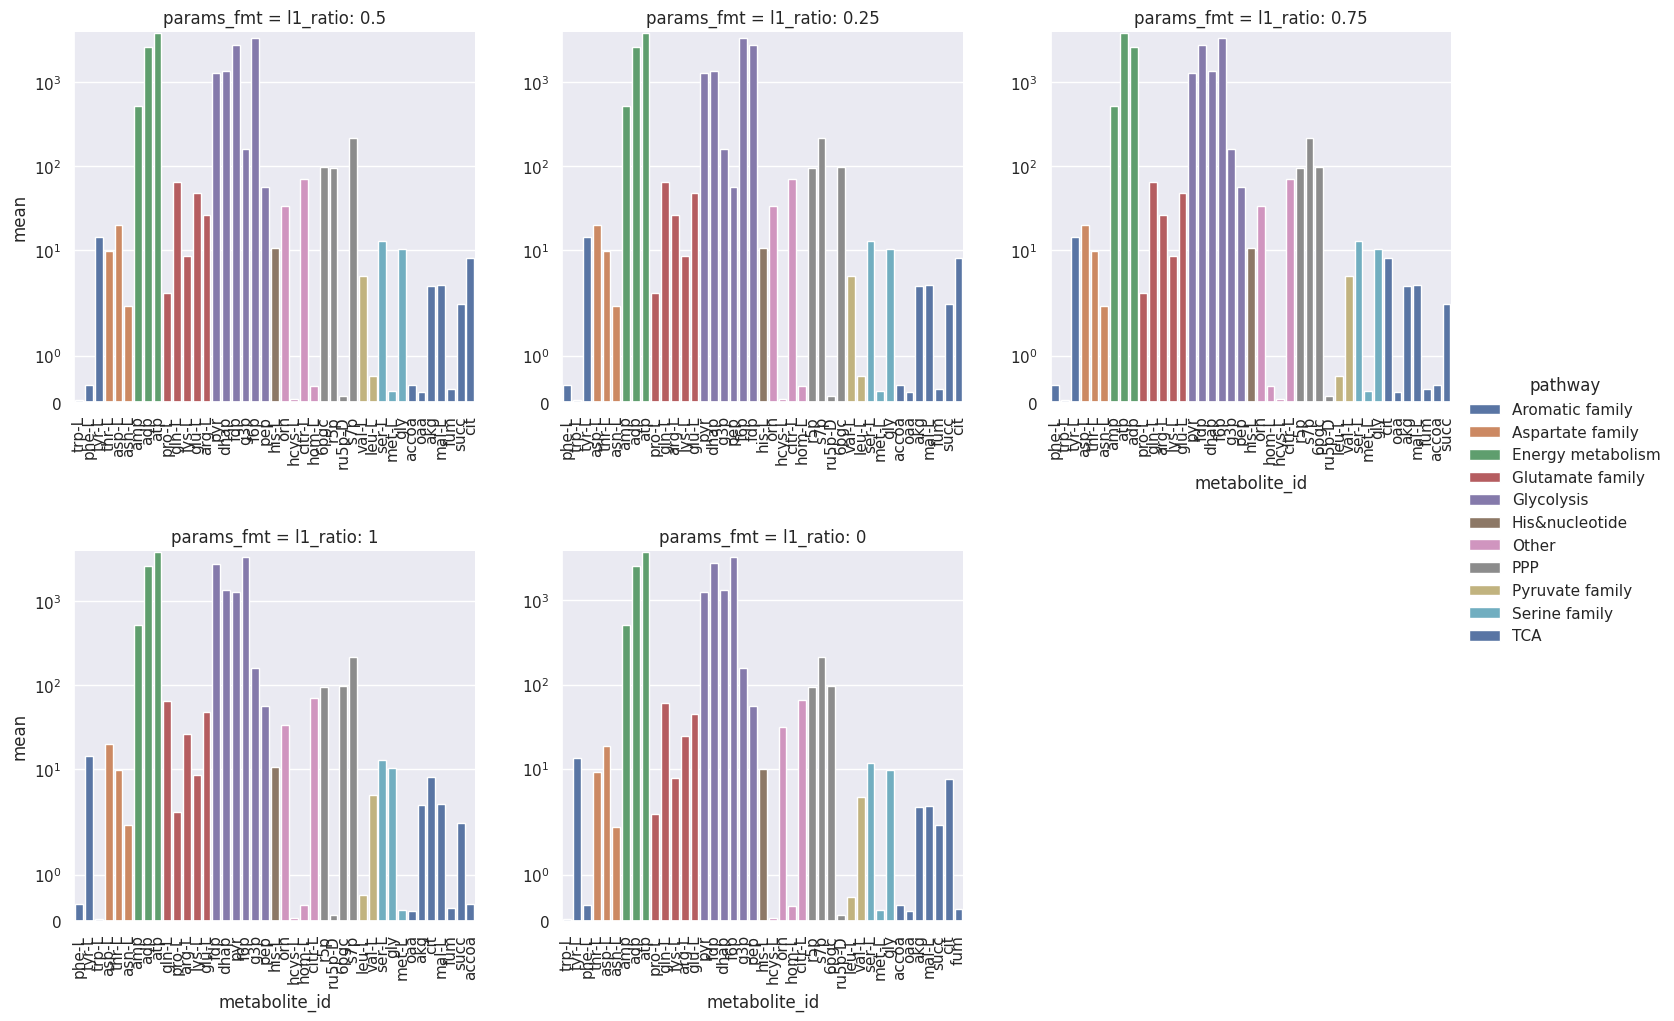

In [49]:
for reggressor in df['regressor'].unique():
    _df = df[df['regressor'] == reggressor].sort_values('pathway')
    g = sns.catplot(
        x='metabolite_id',
        y='mean',
        hue='pathway',
        # row='regressor',
        col='params_fmt',
        col_wrap=3,
        sharey=False,
        sharex=False,
        kind='bar',
        data=_df,
        dodge=False,
        palette='deep',
        # legend=False,
    )

    g.set(yscale='symlog')
    g.set_xticklabels(rotation=90)
    plt.subplots_adjust(hspace=0.4)
    # plt.legend(bbox_to_anchor=(0.8, 0.5), loc='center left',)
    # plt.tight_layout()

In [ ]:
best_models = df[df['rank'] == 1]
best_models['params_fmt']

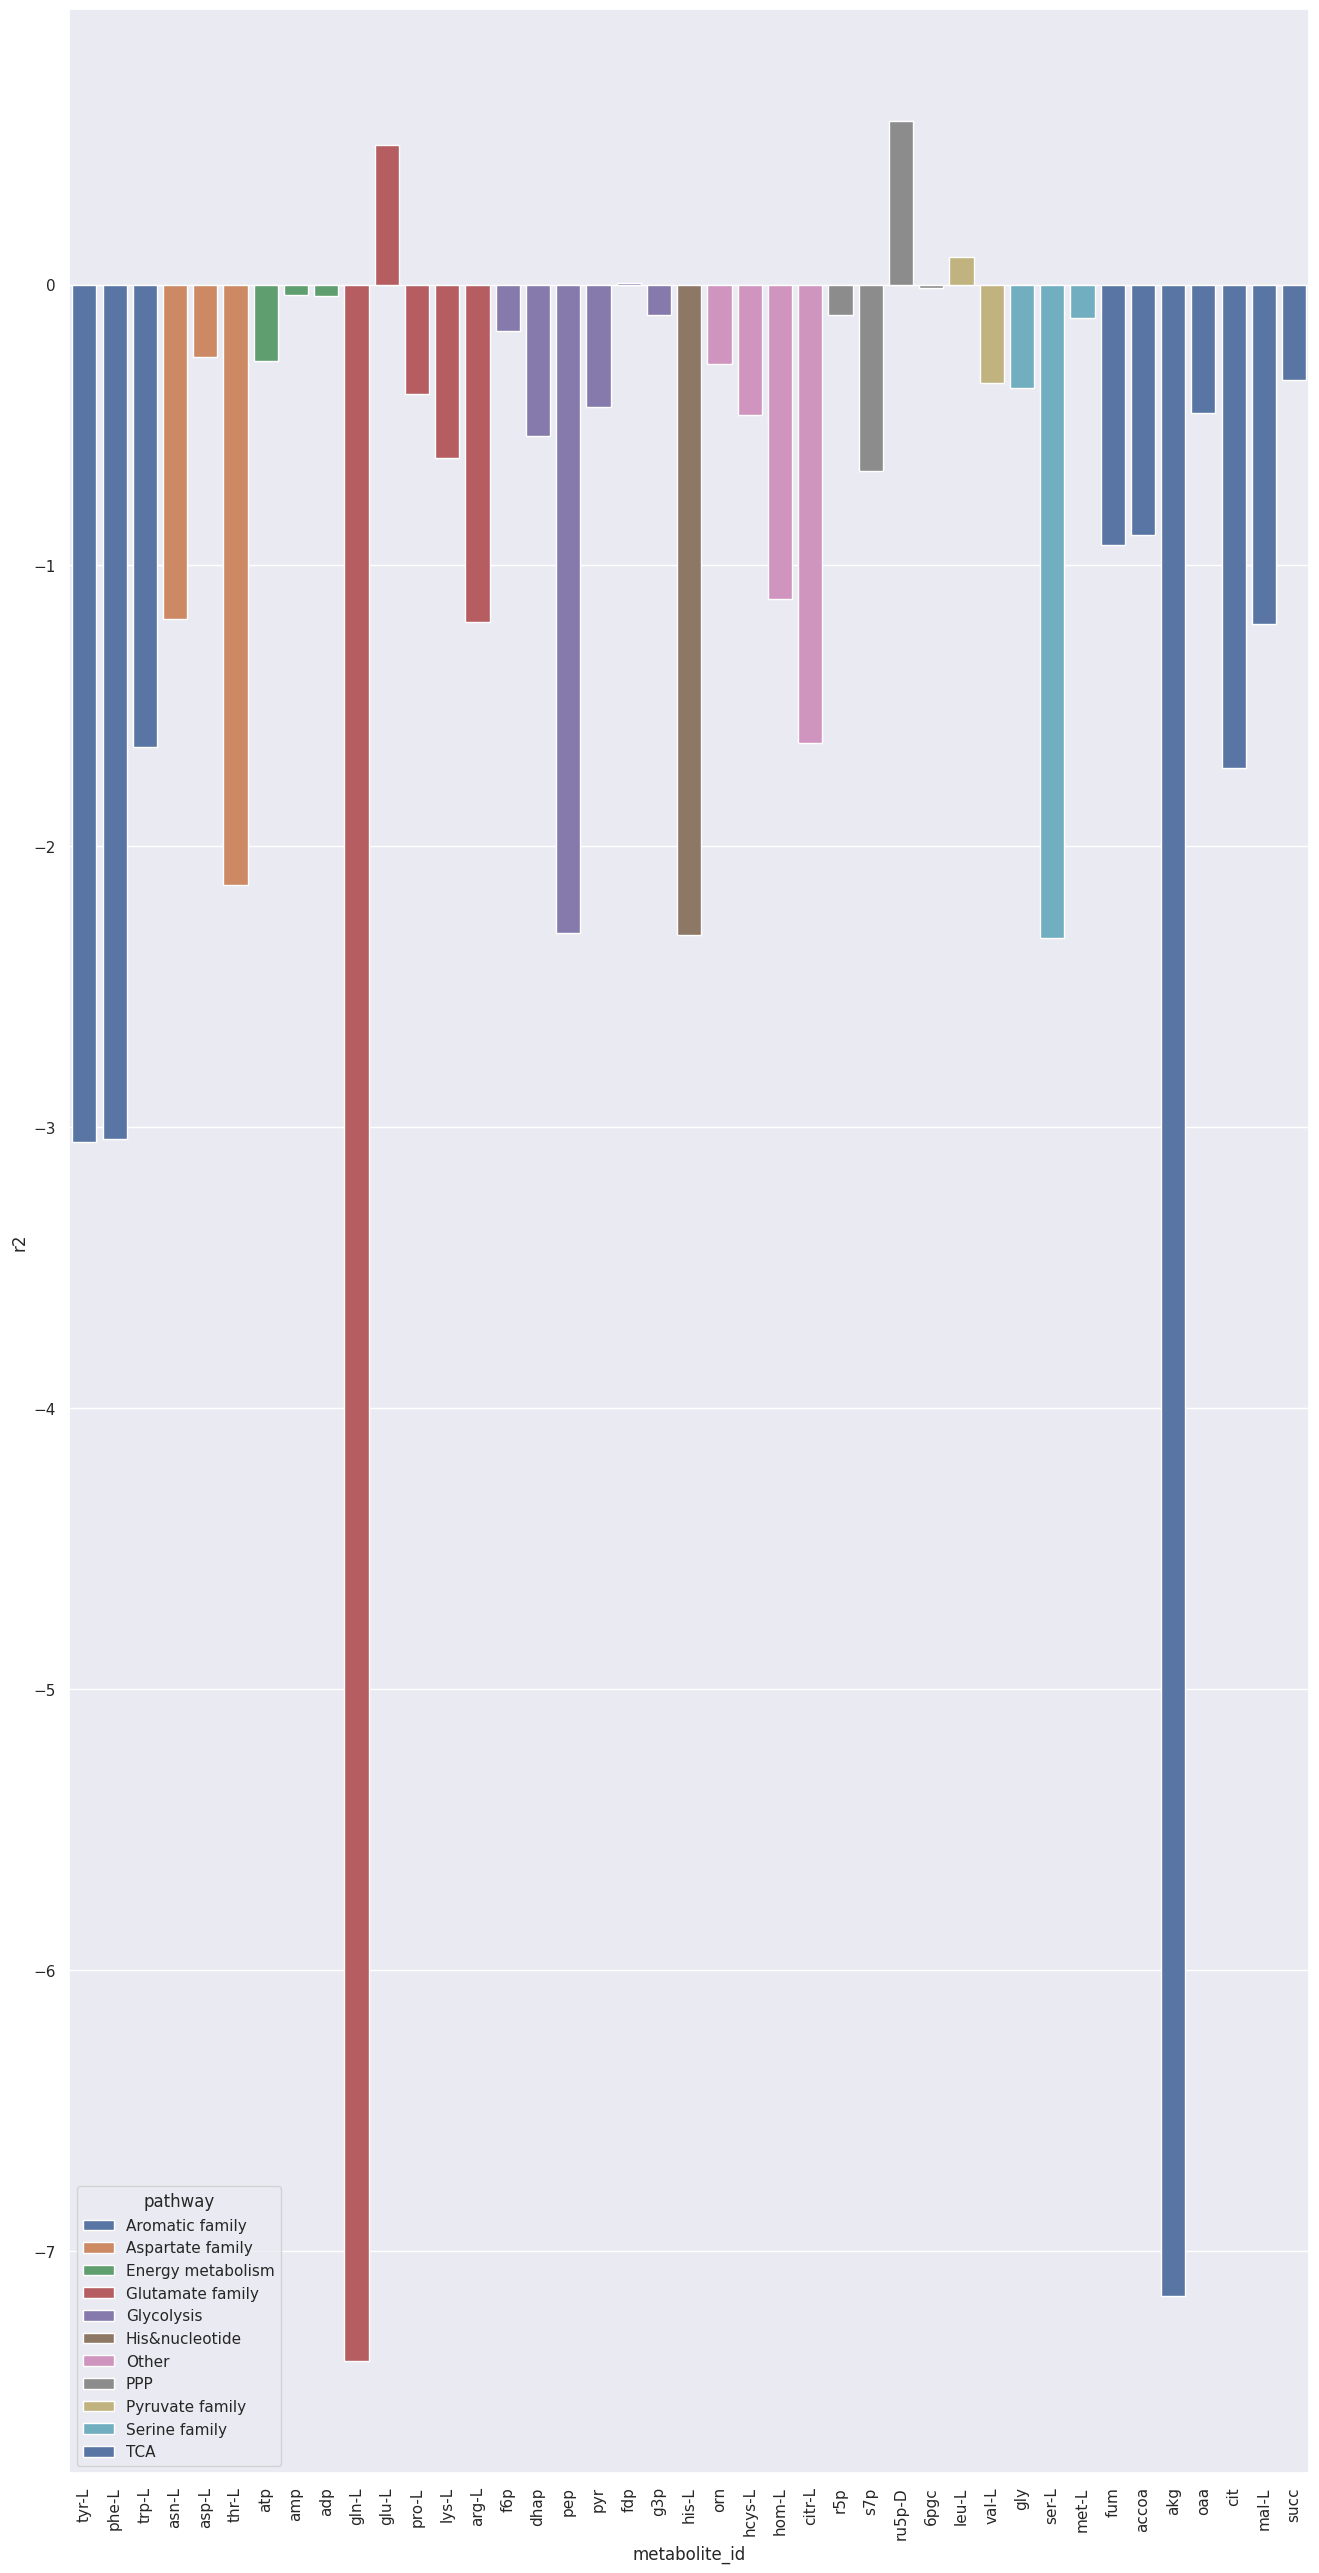

In [69]:
_df = test_df.sort_values('pathway')
g = sns.barplot(
    data=_df,
    x='metabolite_id',
    y='r2',
    hue='pathway',
    dodge=False,
    palette='deep',
)
# g.set(yscale='symlog')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()